## ひらがな手書きの文字認識

### データのダウンロード（NDL LABからひらがなのデータ）

In [5]:
%matplotlib inline

In [6]:
notebook_id = %env TRAINING_NOTEBOOK_ID
%cd '/mnt/notebooks/{notebook_id}/Platform_handson/hiragana_classify'

/mnt/notebooks/1736464579666/Platform_handson/hiragana_classify


In [7]:
# home配下にdataを配置する
!wget http://lab.ndl.go.jp/dataset/hiragana73.zip -P /home/data

--2019-04-14 04:56:08--  http://lab.ndl.go.jp/dataset/hiragana73.zip
Resolving lab.ndl.go.jp (lab.ndl.go.jp)... 202.32.173.150
Connecting to lab.ndl.go.jp (lab.ndl.go.jp)|202.32.173.150|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://lab.ndl.go.jp/dataset/hiragana73.zip [following]
--2019-04-14 04:56:08--  https://lab.ndl.go.jp/dataset/hiragana73.zip
Connecting to lab.ndl.go.jp (lab.ndl.go.jp)|202.32.173.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233312433 (223M) [application/zip]
Saving to: ‘/home/data/hiragana73.zip.1’

hiragana73.zip.1    100%[===================>] 222.50M  10.5MB/s    in 22s     

2019-04-14 04:56:30 (10.0 MB/s) - ‘/home/data/hiragana73.zip.1’ saved [233312433/233312433]



In [16]:
n_files = !unzip -l /home/data/hiragana73.zip | grep .png | wc -l
!unzip -o /home/data/hiragana73.zip -d /home/data/ | pv -l -s {n_files[0]} > /dev/null

  80k 0:00:13 [5.74k/s] [====================================>] 100%            


In [17]:
ls -al /home/data/hiragana73

total 4676
drwxr-xr-x 75 root root  4096 Sep  8  2016 ./
drwxr-xr-x  3 root root    70 Apr 14 04:56 ../
drwxr-xr-x  2 root root 45056 Apr 14 05:06 U3042/
drwxr-xr-x  2 root root 45056 Apr 14 05:06 U3044/
drwxr-xr-x  2 root root 45056 Apr 14 05:06 U3046/
drwxr-xr-x  2 root root 40960 Apr 14 05:06 U3048/
drwxr-xr-x  2 root root 49152 Apr 14 05:06 U304A/
drwxr-xr-x  2 root root 49152 Apr 14 05:06 U304B/
drwxr-xr-x  2 root root 45056 Apr 14 05:06 U304C/
drwxr-xr-x  2 root root 45056 Apr 14 05:06 U304D/
drwxr-xr-x  2 root root 40960 Apr 14 05:06 U304E/
drwxr-xr-x  2 root root 49152 Apr 14 05:06 U304F/
drwxr-xr-x  2 root root 40960 Apr 14 05:06 U3050/
drwxr-xr-x  2 root root 45056 Apr 14 05:06 U3051/
drwxr-xr-x  2 root root 40960 Apr 14 05:06 U3052/
drwxr-xr-x  2 root root 45056 Apr 14 05:06 U3053/
drwxr-xr-x  2 root root 40960 Apr 14 05:06 U3054/
drwxr-xr-x  2 root root 49152 Apr 14 05:06 U3055/
drwxr-xr-x  2 root root 40960 Apr 14 05:06 U3056/
drwxr-xr-x  2 root root 49152 Apr 14 05:06 U30

In [18]:
# フォルダの一覧を取得する(hiragana73配下)
import os
path = "/home/data/hiragana73/"
folder = os.listdir(path)
# フォルダは Unicode 表記の平仮名なので、50音順になるように sort しておく
folder.sort()

### 前処理

In [19]:
import glob
import numpy as np
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

image_size = 48
 
X = []
Y = []

for index, name in tqdm(enumerate(folder), total=len(folder)):
    pattern = os.path.join(path, name, '*.png')
    for file in glob.glob(pattern):
      image = Image.open(file)
      image = image.convert("RGB")
      #image = image.convert('L')
      image = image.resize((image_size, image_size))
      data = np.asarray(image)
      X.append(data)
      Y.append(index)
 
# 学習とテストで 8:2 のデータ割合に分ける
X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(X), np.array(Y),
    train_size=0.8, test_size=0.2)

In [20]:
# ラベルと対象データを確認
Y_train[1]

13

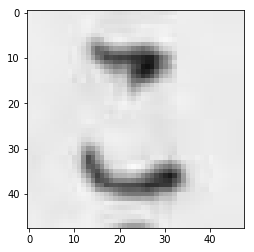

In [21]:
import matplotlib.pyplot as plt
im_list = np.asarray(X_train[1])
plt.imshow(im_list)
plt.show()

In [22]:
# trainとtestがデータが分割されていることを確認する
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

64000
64000
16000
16000


In [23]:
# 0-255の整数値を0〜1の小数に変換する(正規化)
X_train_orig = X_train
X_test_orig = X_test
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [24]:
# one-hot vector形式に変換する
from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train, 73)
Y_test = np_utils.to_categorical(Y_test, 73)

Using TensorFlow backend.


In [25]:
# モデルの定義（別資料にて説明）
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(73, activation='softmax'))

In [26]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [27]:
history = model.fit(X_train, Y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Train on 64000 samples, validate on 16000 samples
Epoch 1/20
64000/64000 [==============================] - 17s 264us/step - loss: 4.2050 - acc: 0.0303 - val_loss: 3.8648 - val_acc: 0.1114
Epoch 2/20
64000/64000 [==============================] - 15s 231us/step - loss: 2.5528 - acc: 0.3402 - val_loss: 0.9816 - val_acc: 0.7976
Epoch 3/20
64000/64000 [==============================] - 15s 231us/step - loss: 0.9706 - acc: 0.7320 - val_loss: 0.3699 - val_acc: 0.9197
Epoch 4/20
64000/64000 [==============================] - 15s 234us/step - loss: 0.5308 - acc: 0.8513 - val_loss: 0.2163 - val_acc: 0.9503
Epoch 5/20
64000/64000 [==============================] - 15s 231us/step - loss: 0.3624 - acc: 0.8995 - val_loss: 0.1639 - val_acc: 0.9609
Epoch 6/20
64000/64000 [==============================] - 15s 231us/step - loss: 0.2740 - acc: 0.9222 - val_loss: 0.1309 - val_acc: 0.9675
Epoch 7/20
64000/64000 [==============================] - 15s 232us/step - loss: 0.2203 - acc: 0.9370 - val_loss: 0.

In [28]:
predict = model.predict(X_test)

In [29]:
len(predict)

16000

In [30]:
# ラベルの設定
label = ["あ","い","う","え","お","か","が","き","ぎ","く","ぐ","け","げ","こ","ご","さ","ざ","し","じ","す","ず","せ","ぜ","そ","ぞ","た","だ","ち","ぢ","つ","づ","て","で","と","ど","な","に","ぬ","ね","の","は","ば","ぱ","ひ","び","ぴ","ふ","ぶ","ぷ","へ","べ","ぺ","ほ","ぼ","ぽ","ま","み","む","め","も","や","ゆ","よ","ら","り","る","れ","ろ","わ","ゐ","ゑ","を","ん"]

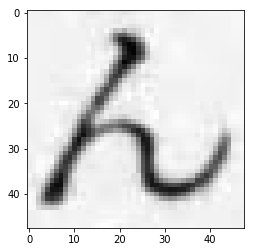

In [31]:
import matplotlib.pyplot as plt
ind = 500
im_list = np.asarray(X_test_orig[ind])
plt.imshow(im_list)
plt.show()

In [32]:
label[predict[ind].tolist().index(max(predict[ind]))]

'ん'

In [33]:
#モデルの保存
model.save('./model/hiragana_model.h5', include_optimizer=False)

In [34]:
from keras.models import load_model
import numpy as np
from keras.preprocessing.image import img_to_array, load_img

jpg_name = ''

model=load_model('./model/hiragana_model.h5')

img_path = ('./sample/test2.png')
img = img_to_array(load_img(img_path, target_size=(48,48)))
img_nad = img_to_array(img)/255
img_nad = img_nad[None, ...]

label=["あ","い","う","え","お","か","が","き","ぎ","く","ぐ","け","げ","こ","ご","さ","ざ","し","じ","す","ず","せ","ぜ","そ","ぞ","た","だ","ち","ぢ","つ","づ","て","で","と","ど","な","に","ぬ","ね","の","は","ば","ぱ","ひ","び","ぴ","ふ","ぶ","ぷ","へ","べ","ぺ","ほ","ぼ","ぽ","ま","み","む","め","も","や","ゆ","よ","ら","り","る","れ","ろ","わ","ゐ","ゑ","を","ん"]
pred = model.predict(img_nad, batch_size=1, verbose=0)
score = np.max(pred)
pred_label = label[np.argmax(pred[0])]
print('name:',pred_label)
print('score:',score)

name: う
score: 0.9988631


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [35]:
# HTTPサーバに組みこむ際のサンプルコード
from keras.models import load_model
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

model=load_model('./model/hiragana_model.h5')

def process_image(img):
    img = Image.fromarray(img)
    img = img.resize((48, 48)).convert('RGB')
    
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x, mode='tf')

    label=["あ","い","う","え","お","か","が","き","ぎ","く","ぐ","け","げ","こ","ご","さ","ざ","し","じ","す","ず","せ","ぜ","そ","ぞ","た","だ","ち","ぢ","つ","づ","て","で","と","ど","な","に","ぬ","ね","の","は","ば","ぱ","ひ","び","ぴ","ふ","ぶ","ぷ","へ","べ","ぺ","ほ","ぼ","ぽ","ま","み","む","め","も","や","ゆ","よ","ら","り","る","れ","ろ","わ","ゐ","ゑ","を","ん"]
    pred = model.predict(x,verbose=0)[0]
    print(pred)
    result_with_labels = [{"label": label[i], "probability": float(score)} for i, score in enumerate(pred)]
    result = {"result":sorted(result_with_labels, key=lambda x: x['probability'], reverse=True)[:5]}

    return result

def handler(iter, context):
    for img in iter:
        yield process_image(img)

In [36]:
#img = Image.open('./test.png')
img = Image.open('./sample/test4.png')
img = np.asarray(img)
process_image(img)

[7.4382829e-06 2.8569837e-11 4.7673679e-05 7.3069924e-01 8.5597785e-06
 2.2180767e-07 1.2219082e-09 1.8823082e-05 4.2051920e-06 2.1858150e-04
 1.3728683e-07 1.1203432e-09 4.3593389e-11 3.0722229e-05 3.5691909e-07
 4.5003698e-04 3.5336645e-06 1.6762047e-05 2.0647948e-07 7.6740334e-06
 2.0776845e-08 6.1004295e-07 4.8975570e-09 1.0654498e-04 5.3555766e-08
 2.4528947e-06 7.4200813e-08 2.8671752e-04 3.3469129e-07 2.6842636e-06
 2.1956936e-09 1.1892011e-03 1.0810955e-06 1.1992943e-03 1.4048549e-06
 1.7566131e-04 3.1679126e-06 3.0692033e-07 1.9626395e-06 1.9293050e-07
 1.9598490e-04 1.1064555e-04 9.7789075e-07 1.4660564e-05 8.8232906e-07
 6.3681399e-10 1.7039153e-01 8.8709538e-05 1.5602785e-05 1.2139368e-07
 5.4283728e-06 9.4308810e-08 3.8946844e-05 2.4232189e-03 3.0767413e-05
 3.9551057e-02 7.4005348e-04 2.4283182e-08 3.6018080e-09 3.6809098e-03
 2.8598503e-08 1.5380637e-08 9.1132283e-04 6.4593600e-03 2.2761892e-06
 2.8332315e-02 1.8883629e-06 1.5912419e-05 1.7960707e-08 1.0182603e-06
 9.598

{'result': [{'label': 'え', 'probability': 0.7306992411613464},
  {'label': 'ふ', 'probability': 0.1703915297985077},
  {'label': 'ま', 'probability': 0.039551056921482086},
  {'label': 'る', 'probability': 0.028332315385341644},
  {'label': 'ゑ', 'probability': 0.00959872454404831}]}

この後、modelフォルダに存在するh5ファイルとmain.pyを圧縮し
ABEJA Platform上にアップロードすることで、HTTPサーバとして活用可能

## Imagegeneratorを使う場合(参考程度に記載)

In [37]:
from keras.preprocessing.image import ImageDataGenerator

In [38]:
datagen = ImageDataGenerator(rescale=1./255,
    #shear_range=0.1,
    #zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set test split

In [39]:
dir = '/home/data/hiragana73'
train_generator = datagen.flow_from_directory(
        dir,     # directory
        target_size=(48, 48),     # input shape (resized to 150x150)
        batch_size=20,
        class_mode='categorical')    # categorical labels

Found 80000 images belonging to 73 classes.


In [40]:
test_generator = datagen.flow_from_directory(
    dir, # same directory as training data
    target_size=(48, 48),
    batch_size=20,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 15973 images belonging to 73 classes.


In [41]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(73, activation='softmax'))

from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [42]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=354,
      epochs=20,
      validation_data=test_generator,
      validation_steps=56)

Epoch 1/20
354/354 [==============================] - 4s 13ms/step - loss: 4.2793 - acc: 0.0171 - val_loss: 4.2686 - val_acc: 0.0134
Epoch 2/20
354/354 [==============================] - 4s 11ms/step - loss: 4.2639 - acc: 0.0175 - val_loss: 4.2525 - val_acc: 0.0205
Epoch 3/20
354/354 [==============================] - 4s 11ms/step - loss: 4.2471 - acc: 0.0189 - val_loss: 4.2048 - val_acc: 0.0589
Epoch 4/20
354/354 [==============================] - 4s 11ms/step - loss: 4.1633 - acc: 0.0390 - val_loss: 3.9425 - val_acc: 0.0982
Epoch 5/20
354/354 [==============================] - 4s 11ms/step - loss: 3.7972 - acc: 0.0883 - val_loss: 3.2161 - val_acc: 0.2188
Epoch 6/20
354/354 [==============================] - 4s 11ms/step - loss: 3.2666 - acc: 0.1770 - val_loss: 2.4748 - val_acc: 0.4196
Epoch 7/20
354/354 [==============================] - 4s 11ms/step - loss: 2.6793 - acc: 0.2992 - val_loss: 1.6870 - val_acc: 0.5955
Epoch 8/20
354/354 [==============================] - 4s 11ms/step - 

In [43]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

test_loss, test_acc = model.evaluate_generator(test_generator, steps=54)
print('test loss:', test_loss)
print('test acc:', test_acc)

test loss: 0.2694622940832266
test acc: 0.9342592535195527
